# PA005: High Value Customer Identification (Insiders)

## 0.0 Solution Planning (IOT)

### Inputs

1. Business Problem
    - Select the most valuable customers to integrate a fidelity program.
    
2. Dataset
    - Sales of an online e-commerce along one year.

### Outputs

1. Identification of the people to integrate the insiders program.
    - List: client_id | is_insider |
               10323  | yes/1
               32514  | no/0

2. Report answering the business questions:
    - Who are the elegible people for the insiders program?
    - How many will integrate the insiders program?
    - What are the main characteristics of those clients?
    - What is the revenue percentage brought by those clients?
    - What is the expected revenue brought by those clients in the next few months?
    - What are the conditions to make a person elegible to the insiders program?
    - What are the conditions to remove a person from the insiders program?
    - Which warranty ensures the insiders program is better than the rest marketing plan?
    - What actions may the marketing team apply to raise the revenue?

### Tasks

1. Who are the elegible people for the insiders program?
    - What is being more valuable? What are the "highest value" clients?
    - Revenue:
        - High average ticket;
        - High LTV (lifetime value);
        - High frequency;
        - High basket size;
        - Low churn probability;
        - High LTV prediction;
        - High purchase probability;
        
    - Cost:
        - Low return rate;
        
    - Sales experience:
        - High average evaluation
        
2. How many will integrate the insiders program?
    - What is the total client number?
    - % of the insiders group
    
3. What are the main characteristics of those clients?
    - Describe client characteristics:
        - Age;
        - Location;
        
    - Describe consumption characteristics:
        - Clustering features;
        
4. What is the revenue percentage brought by those clients?
    - Anual total revenue;
    - Total anual revenue generated by the insiders;
    
5. What is the expected revenue brought by those clients in the next few months?
    - Insiders LTV;
    - Cohort analysis;
    
6. What are the conditions to make a person elegible to the insiders program?
    - Define frequency (1 month, 3 months)
    - The person must be similar to the other insiders
    
7. What are the conditions to remove a person from the insiders program?
    - Define frequency (1 month, 3 months)
    - The person must not be similar to the other insiders
    
8. Which warranty ensures the insiders program is better than the rest marketing plan?
    - A/B testing
    - A/B bayesean testing
    - Hyphotesis testing
    
9. What actions may the marketing team apply to raise the revenue?
    - Promotion
    - Purchase preference
    - Delivery cost
    - Company visit

### Solutions benchmark
#### 1. Desk Research

Research for methodologies that may be applied in this context

## 0.1. Imports

In [41]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from matplotlib      import pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.2. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()


jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Dataset

In [3]:
# load
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# <font color='orange'> 1.0. Data Description </font>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
# divide dataframe into missing and non-missing customer_id
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# test if there are matching invoices 
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [12]:
# create fake customer_ids to model customers' behaviour
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge with original data based on invoice_no
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce: merge customer_id_x and customer_id_y
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra customer_id columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
59648,541370,22956,36 FOIL HEART CAKE CASES,6,15-Jan-17,2.10,United Kingdom,18179.0
28880,538662,85169B,BLACK LOVE BIRD CANDLE,24,11-Dec-16,0.42,United Kingdom,15159.0
276135,561033,22431,WATERING CAN BLUE ELEPHANT,6,22-Jul-17,1.95,United Kingdom,14443.0
400057,571294,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,2,14-Oct-17,1.25,United Kingdom,16987.0
212958,555514,23263,SET OF 3 WOODEN HEART DECORATIONS,24,3-Jun-17,1.25,United Kingdom,17071.0


In [13]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [17]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### <font color='red'> 1.7.1.1 Numerical Attributes - understanding </font>

1. Negative quantity ( can it be a return? )
2. Unit price = 0 ( can it be a promotion? )

### 1.7.2. Categorical Attributes

#### Invoice Number

In [18]:
# problem: invoice with letters and numbers
# df1['invoice_no'].astype(int)

# find non-numeric characters
df_letter_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoice.head()

print('Number of entries with a non-numerical character in the invoice_no: {}'.format(len(df_letter_invoice)))
print('Number of negative quantities: {}'.format(len(df_letter_invoice[df_letter_invoice['quantity'] < 0])))

Number of entries with a non-numerical character in the invoice_no: 9291
Number of negative quantities: 9288


#### Stock Code

In [19]:
# check non-numeric stock_code
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+', x))), 'stock_code'].unique()

# Action: remove stock_code in ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

#### Description

In [20]:
df1.head() # ['description']

# Action: delete description column

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [21]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [22]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [23]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color='orange'> 2.0. Data Filtering </font>

In [24]:
df2 = df1.copy()

df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [25]:
# =========== Numerical Attributes ====

# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]


# =========== Categorical Attributes ====

# stock code != ['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE','DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm','gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055','DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY','DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073','DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE','DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm','gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055','DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY','DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073','DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity: separate into 2 dataframes - negative quantity means return, positive means purchase
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# <font color='orange'> 3.0. Feature Engineering </font>

In [49]:
# Feature ideas for future reference:

# Moving average - 7d, 14d, 30d
# Number of purchases per month, purchases before and after the 15th day
# Average 

In [50]:
df3 = df2.copy()

## 3.1. Feature Creation

In [51]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [52]:
# Gross revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

/home/debora/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    67
dtype: int64

### 3.1.2. Recency - Days since last purchase

In [53]:
# Recency - depends on the number of product returns
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
dtype: int64

### 3.1.3. Number of purchases

In [55]:
# no of purchases
df_aux = (df2_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                    .groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename(columns={'invoice_no': 'qt_invoices'}))

df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qt_invoices      67
dtype: int64

### 3.1.4. No of items aquired

In [56]:
df_aux = (df2_purchase[['customer_id', 'quantity']].groupby('customer_id')
                                                  .sum()
                                                  .reset_index()
                                                  .rename(columns={'quantity': 'no_items'}))
            
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qt_invoices      67
no_items         67
dtype: int64

### 3.1.5. Assortment

In [57]:
df_aux = (df2_purchase[['customer_id', 'stock_code']].groupby('customer_id')
                                                    .count()
                                                    .reset_index()
                                                    .rename(columns={'stock_code': 'assortment'}))
            
df_ref = pd.merge(df_ref, df_aux, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qt_invoices      67
no_items         67
assortment       67
dtype: int64

### 3.1.6. Average ticket

In [58]:
# Average ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2)

df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    67
recency_days     67
qt_invoices      67
no_items         67
assortment       67
avg_ticket       67
dtype: int64

### 3.1.7. Average time between purchases

In [59]:
# average no of days between purchases
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False', 'False'])

df_aux['next_customer_id'] = df_aux['customer_id'].shift() # last customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # last invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# calculate avg
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qt_invoices           67
no_items              67
assortment            67
avg_ticket            67
avg_recency_days    2794
dtype: int64

### 3.1.8. Frequency purchase

In [60]:
df_aux = (df3[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                 .groupby('customer_id')
                                                 .agg(max_ = ('invoice_date', 'max'), 
                                                      min_ = ('invoice_date', 'min'), days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1), 
                                                      buy_ = ('invoice_no', 'count'))).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qt_invoices           67
no_items              67
assortment            67
avg_ticket            67
avg_recency_days    2794
frequency              0
dtype: int64

### 3.1.9. Returns

In [61]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qt_returned'})
df_returns['qt_returned'] = df_returns['qt_returned'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')

df_ref.loc[df_ref['qt_returned'].isna(), 'qt_returned'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qt_invoices           67
no_items              67
assortment            67
avg_ticket            67
avg_recency_days    2794
frequency              0
qt_returned            0
dtype: int64

### 3.1.10. Basket size - No of products per purchase

In [62]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchases = ('invoice_no', 'nunique'), 
                                                                             n_products = ('quantity', 'sum'))
                                                                        .reset_index())

# calculate
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qt_invoices           67
no_items              67
assortment            67
avg_ticket            67
avg_recency_days    2794
frequency              0
qt_returned            0
avg_basket_size       67
dtype: int64

### 3.1.11. Avg basket assortment - No of unique products per purchase

In [63]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                        .agg(n_purchases = ('invoice_no', 'nunique'), 
                                                                           n_products = ('stock_code', 'count'))
                                                                        .reset_index())

# calculate
df_aux['avg_assortment'] = df_aux['n_products'] / df_aux['n_purchases']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_assortment']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         67
recency_days          67
qt_invoices           67
no_items              67
assortment            67
avg_ticket            67
avg_recency_days    2794
frequency              0
qt_returned            0
avg_basket_size       67
avg_assortment        67
dtype: int64

In [64]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qt_invoices,no_items,assortment,avg_ticket,avg_recency_days,frequency,qt_returned,avg_basket_size,avg_assortment
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000,0.486111,21.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000,0.048780,6.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500,0.045699,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000,0.136364,22.0,26.666667,1.000000


# <font color='orange'> 4.0. Exploratory Data Analysis </font>

In [65]:
df4 = df_ref.dropna().copy()

df4.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qt_invoices         0
no_items            0
assortment          0
avg_ticket          0
avg_recency_days    0
frequency           0
qt_returned         0
avg_basket_size     0
avg_assortment      0
dtype: int64

## 4.1. Univariate Analysis

In [66]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue

In [67]:
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qt_invoices,no_items,assortment,avg_ticket,avg_recency_days,frequency,qt_returned,avg_basket_size,avg_assortment
1014,14646,279138.02,1.0,72.0,196844.0,2060.0,135.50,7.844444,0.206215,144.0,2733.944444,28.611111
490,18102,259657.30,0.0,60.0,64124.0,431.0,602.45,14.680000,0.163043,0.0,1068.733333,7.183333
432,17450,194550.79,8.0,46.0,69993.0,337.0,577.30,12.821429,0.136111,952.0,1521.586957,7.326087
3325,16446,168472.50,0.0,2.0,80997.0,3.0,56157.50,205.000000,0.014563,80995.0,40498.500000,1.500000
66,14911,136275.72,1.0,198.0,80179.0,5589.0,24.38,2.601399,0.648794,1608.0,404.944444,28.227273
1147,12415,124564.53,24.0,20.0,77373.0,713.0,174.70,20.866667,0.076433,369.0,3868.650000,35.650000
189,14156,116729.63,9.0,54.0,57872.0,1387.0,84.16,7.260000,0.175824,658.0,1071.703704,25.685185
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.56,11.593750,0.120968,125.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.42,9.054054,0.196429,4824.0,648.500000,3.887097
952,16684,66653.56,4.0,28.0,50255.0,277.0,240.63,22.125000,0.084507,864.0,1794.821429,9.892857


In [68]:
df3[df3['customer_id'] == 14646].head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646
37957,539491,20751,1,2016-12-18,2.10,Netherlands,14646
37958,539491,21246,2,2016-12-18,4.95,Netherlands,14646
37959,539491,22960,1,2016-12-18,4.25,Netherlands,14646
37960,539491,22355,2,2016-12-18,0.85,Netherlands,14646
37961,539491,21123,2,2016-12-18,1.25,Netherlands,14646


## 4.2. Bivariate Analysis

In [43]:
!ls -l

total 14320
-rwxrwxrwx 1 debora debora 4206112 Nov  2 12:25 c01_dc_end-to-end_initial_clustering_solution.ipynb
-rwxrwxrwx 1 debora debora  596005 Nov  9 14:45 c02_dc_silhoutte_analysis.ipynb
-rwxrwxrwx 1 debora debora  505821 Nov 11 11:58 c03_dc_descriptive_data_analysis.ipynb
-rwxrwxrwx 1 debora debora  525956 Nov 16 11:29 c04_dc_feature_engineering.ipynb
-rwxrwxrwx 1 debora debora  528043 Nov 16 11:41 c05_dc_exploratory_data_analysis.ipynb
-rwxrwxrwx 1 debora debora       0 Oct 22 17:32 notebook.ipynb
-rwxrwxrwx 1 debora debora 8291859 Nov 16 11:41 output.html


# <font color='orange'> 5.0. Data Preparation </font>

In [33]:
df5 = df4.copy()

In [34]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
# df5['returns'] = ss.fit_transform(df5[['returns']])

In [35]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.378060,2.791504,3.893137,-0.033931
1,13047,0.135805,-0.360996,0.621606,-0.033421
2,12583,0.525545,-0.899714,1.406774,-0.026615
3,13748,-0.120559,0.028079,0.098161,-0.023232
4,15100,-0.128667,2.402430,-0.163561,0.152452


/home/debora/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='gross_revenue', ylabel='Count'>

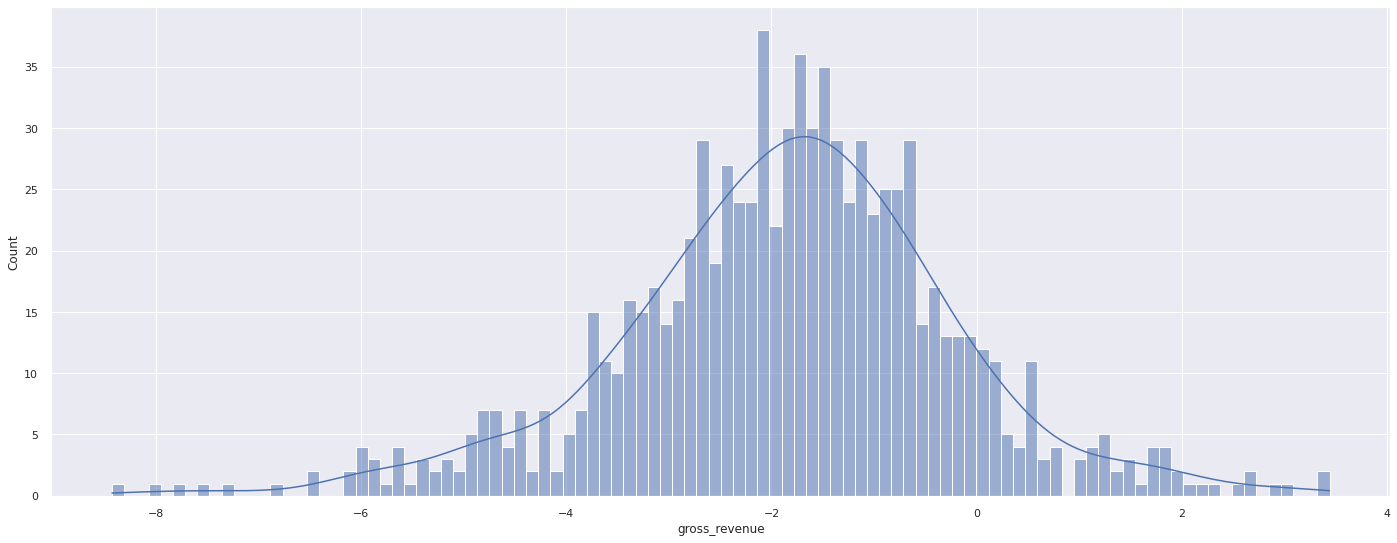

In [36]:
sns.histplot(np.log(df5['gross_revenue']), kde=True, bins=100)

# <font color='orange'> 6.0. Feature Selection </font>

In [37]:
df6 = df5.copy()

# <font color='orange'> 7.0. Hyperparameter Fine Tunning </font>

In [38]:
X = df6.drop(columns=['customer_id'])

In [39]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

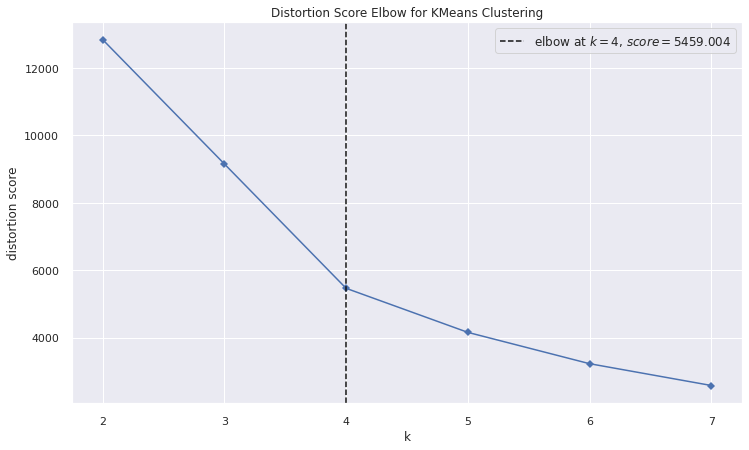

In [40]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)

plt.figure(figsize=(12,7))
kmeans.fit(X)
kmeans.show();

## 7.2. Sillhouette Score

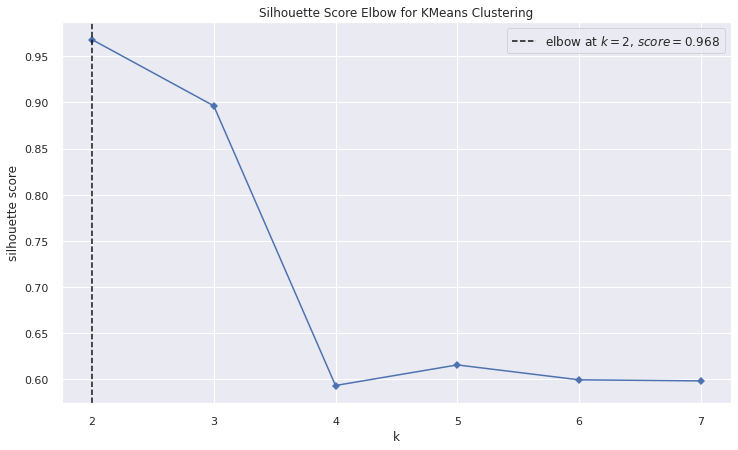

In [41]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)

plt.figure(figsize=(12,7))
kmeans.fit(X)
kmeans.show();

### 7.2.1. Silhouette Analysis

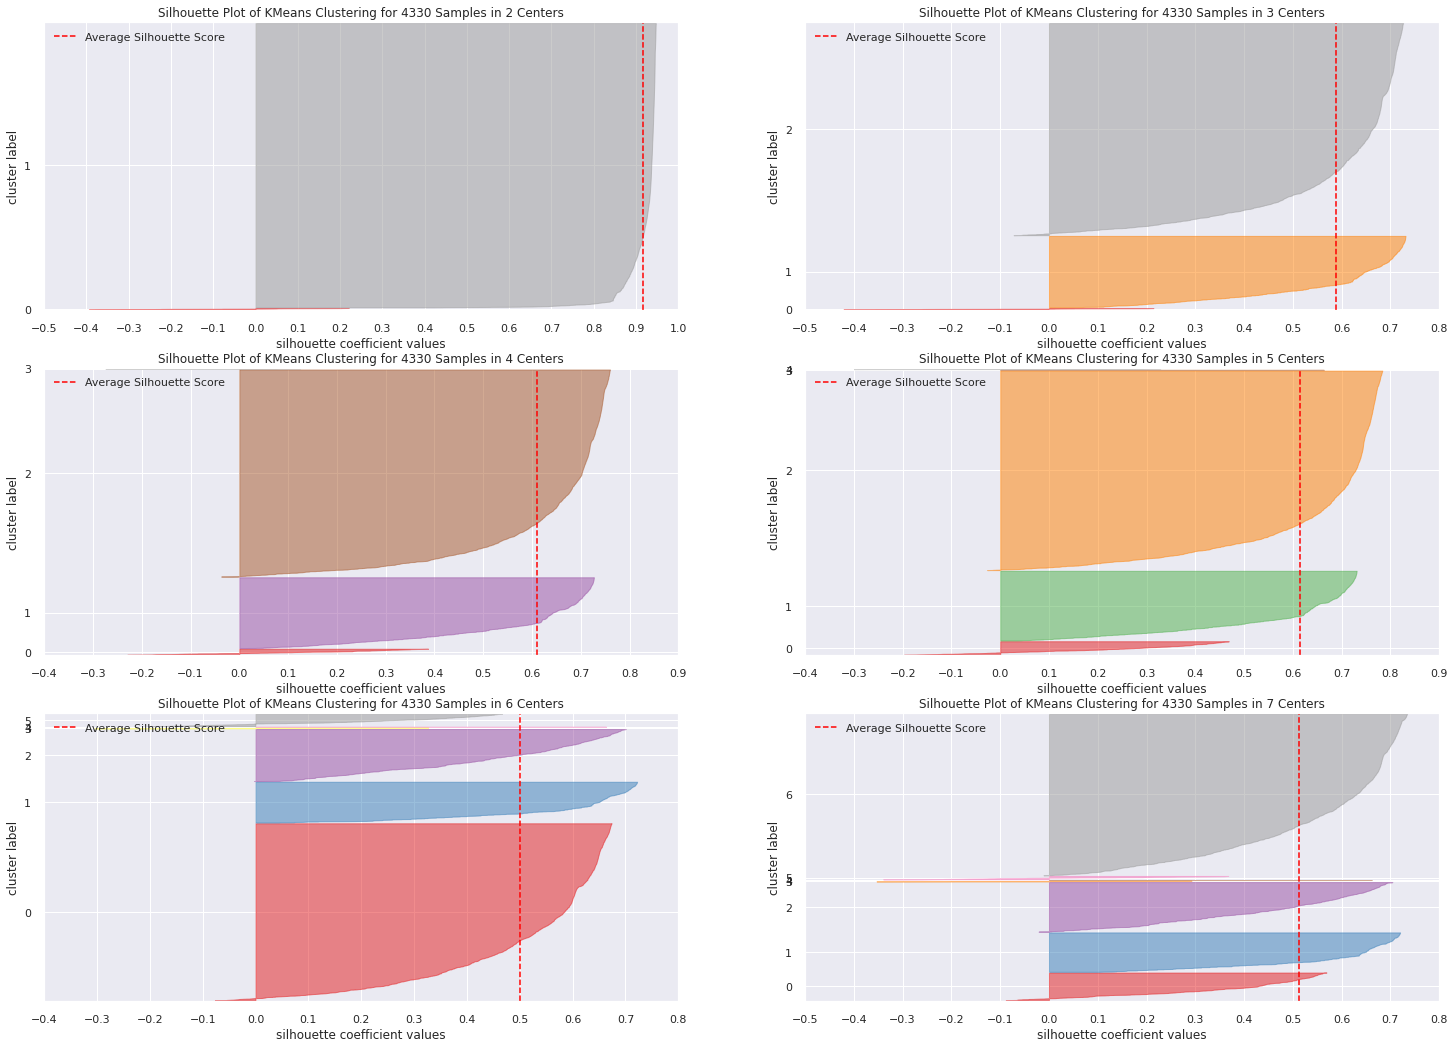

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))

for k in clusters:   
    
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    
    # divisao por moda
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# <font color='orange'> 8.0. Model Training </font>

## 8.1. K-Means

In [43]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [44]:
# WSS (Within-Cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette score)
# print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 9408.141019883187


AttributeError: 'DataFrame' object has no attribute 'silhouette_score'

# <font color='orange'> 9.0. Cluster Analysis </font>

In [45]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.378060,2.791504,3.893137,-0.033931,1
1,13047,0.135805,-0.360996,0.621606,-0.033421,2
2,12583,0.525545,-0.899714,1.406774,-0.026615,2
3,13748,-0.120559,0.028079,0.098161,-0.023232,2
4,15100,-0.128667,2.402430,-0.163561,0.152452,1


## 9.1. Visual inspection

### 9.1.1. Silhouette Score

/home/debora/.local/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


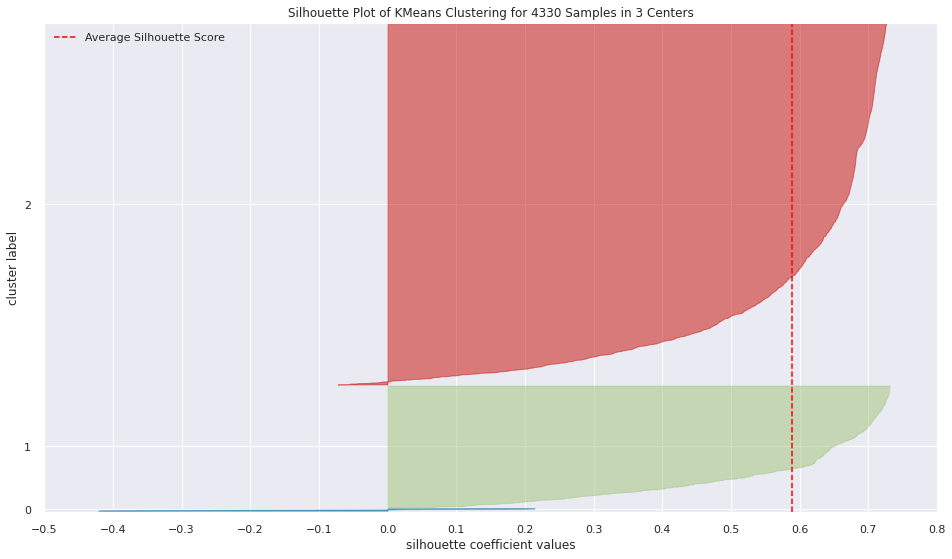

In [46]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

plt.figure(figsize=(16,9))
visualizer.fit(X)
visualizer.finalize()

### 9.1.2. 2D Plot

In [49]:
df_viz = df9.drop(columns='customer_id', axis=1)

# sns.pairplot(df_viz, hue='cluster');

## Machine Learning - Manifold

PCA - Matrix, Espaço de distância - Espaço de Hilbert - 9 condiçoes - Corolários

UMAP, t-SNE (2009) - Manifold - Topologia

### 9.1.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

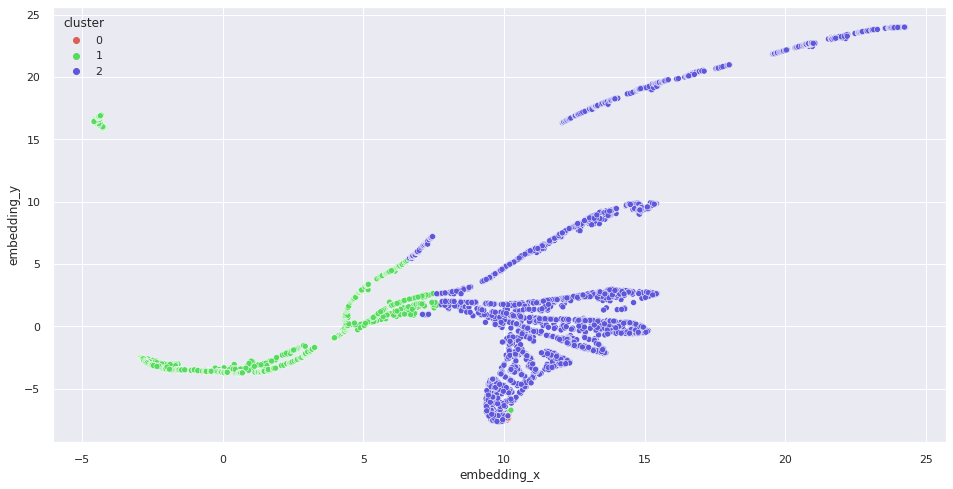

In [50]:
reducer = umap.UMAP(n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(16,8))
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), 
                data=df_viz)

### 9.1.3. t-SNE

## 9.2. Cluster Profile

In [51]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')


# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')


# Avg invoice number
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,22,0.508083,10.330215,-0.722409,8.437592,4.189467
1,1,1086,25.080831,-0.164755,1.538959,-0.350575,-0.008679
2,2,3222,74.411085,-0.015003,-0.513785,0.060552,-0.025680


### Cluster 01:
- Number of customers: ( 93.11 %)
- Avg recency:  96 days
- Avg purchase number: 3 purchases
- Avg gross revenue: 946,69 dollars
- Avg ticket: 25,35 dollars

### Cluster 02 (Insider candidate):
- Number of customers: ( 0.13 %)
- Avg recency: 7 days
- Avg purchase number: 89 purchases
- Avg gross revenue: 182.181,98 dollars
- Avg ticket: 253.626 dollars

### Cluster 03:
- Number of customers: ( 0.64 %)
- Avg recency: 6 days
- Avg purchase number: 57 purchases
- Avg gross revenue: 42.614,38 dollars
- Avg ticket: 162,86 dollars

### Cluster 04:
- Number of customers: ( 6.10 %)
- Avg recency: 20 days
- Avg purchase number: 19 purchases
- Avg gross revenue: 8.089,02 dollars
- Avg ticket: 62,78 dollars


# <font color='orange'> 10.0. Deploy to Production </font>